In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

archive = '/tmp/archive.zip'

ca8a64e6735b60bc60c49342320befcdeaf55f90


In [2]:
!wget https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/data/grenoble_2019-11-25_1895581.zip -O {archive}

--2019-11-25 16:21:21--  https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/data/grenoble_2019-11-25_1895581.zip
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 10654675 (10M) [application/zip]
Sauvegarde en : « /tmp/archive.zip »

/tmp/archive.zip    100%[===================>]  10,16M  --.-KB/s    ds 0,1s    

2019-11-25 16:21:21 (83,1 MB/s) — « /tmp/archive.zip » sauvegardé [10654675/10654675]



In [3]:
df = archive_extraction.read_archive(archive, 'result.csv')
df['mnk'] = df.m * df.n * df.k
df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
df['cpu_id'] = df['node'].astype(str) + ':' + df['cpu'].astype(str)
print(len(df))
df.head()

505760


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,mnk,gflops,cpu_id
0,dgemm,2463,1984,1567,223.619702,0.582005,0,1,dahu,1895581,0,1574669047,0,60887012bf9c7939b9413e00a2fa00c4c563cf885f9a52...,7657289664,26.313489,1:0
1,dgemm,1984,2463,1567,224.201739,0.590913,0,1,dahu,1895581,0,1574669047,1,60887012bf9c7939b9413e00a2fa00c4c563cf885f9a52...,7657289664,25.916813,1:0
2,dgemm,2426,3787,908,224.792662,0.630205,0,1,dahu,1895581,0,1574669047,2,60887012bf9c7939b9413e00a2fa00c4c563cf885f9a52...,8342033896,26.474020,1:0
3,dgemm,403,10290,1287,225.422877,0.441929,0,1,dahu,1895581,0,1574669047,3,60887012bf9c7939b9413e00a2fa00c4c563cf885f9a52...,5337021690,24.153288,1:0
4,dgemm,940,6125,1330,225.864817,0.592521,0,1,dahu,1895581,0,1574669047,4,60887012bf9c7939b9413e00a2fa00c4c563cf885f9a52...,7657475000,25.847092,1:0


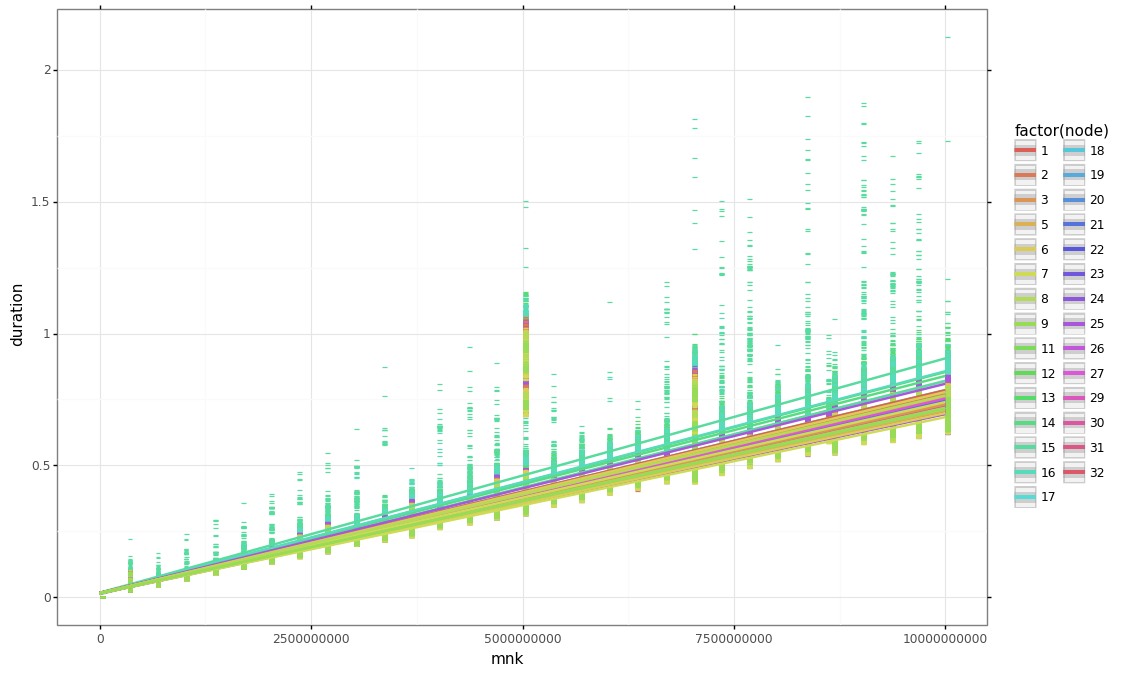

<ggplot: (8759909070975)>

In [4]:
plot = ggplot(df, aes(x='mnk', y='duration', color='factor(node)', group='cpu_id')) + geom_point(shape=1) + geom_smooth(method='lm') + theme_bw()
plot

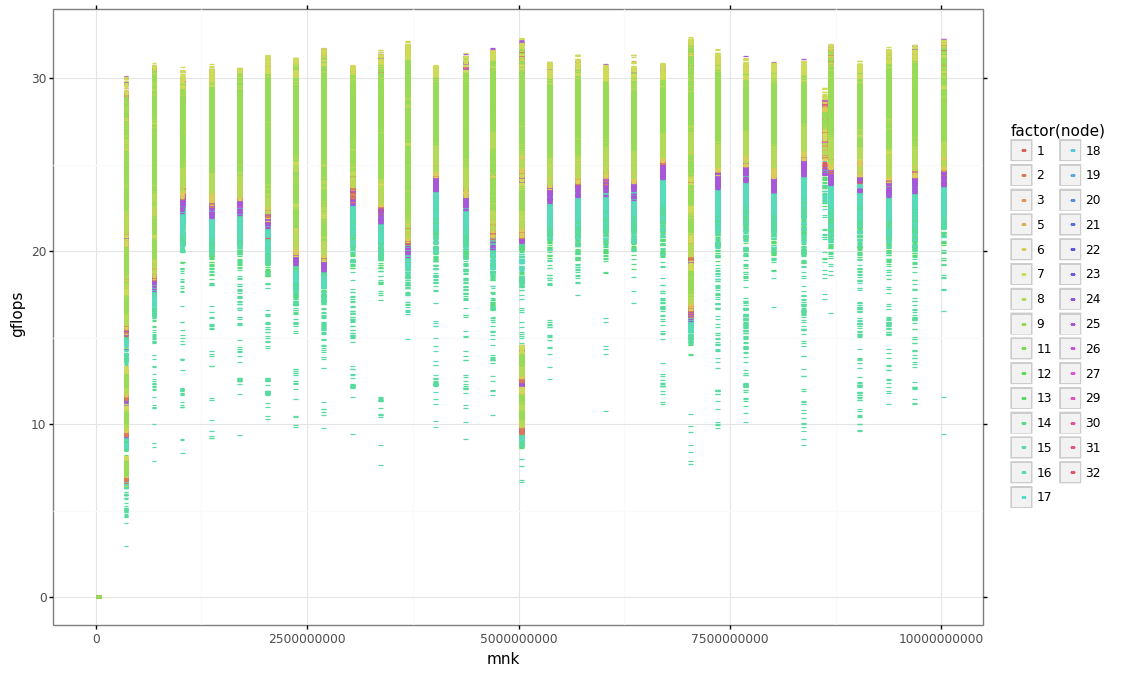

<ggplot: (8759829974483)>

In [5]:
plot = ggplot(df, aes(x='mnk', y='gflops', color='factor(node)', group='cpu_id')) + geom_point(shape=1) + theme_bw()
plot

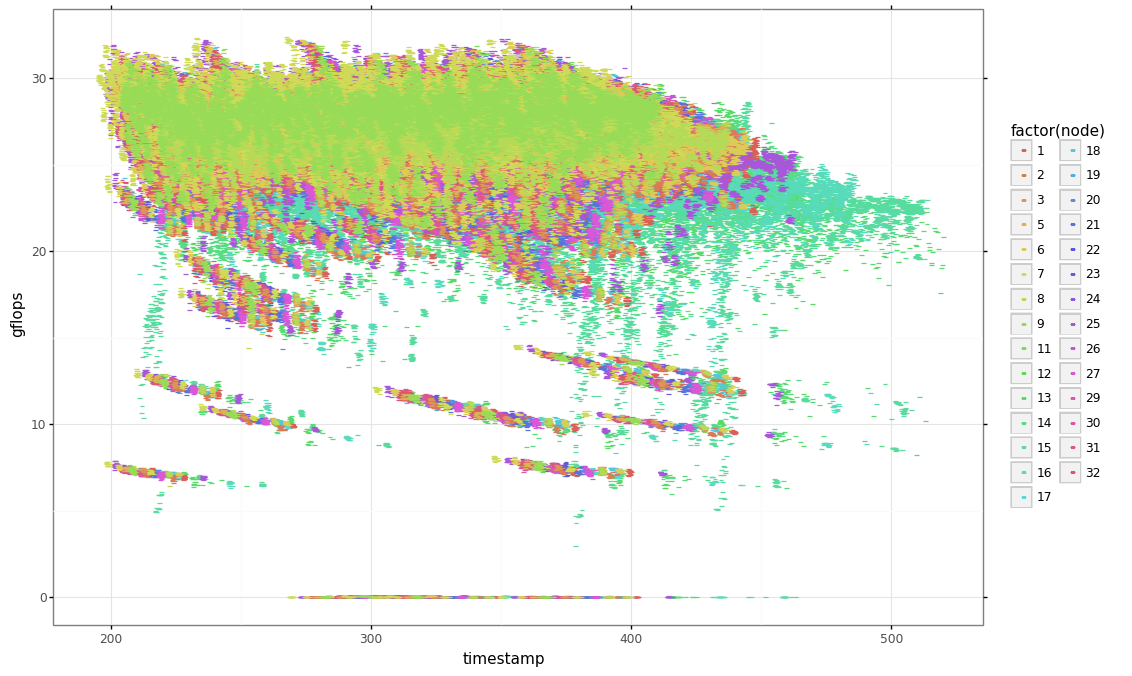

<ggplot: (-9223363276971977335)>

In [6]:
plot = ggplot(df, aes(x='timestamp', y='gflops', color='factor(node)', group='cpu_id')) + geom_point(shape=1) + theme_bw()
plot

In [7]:
%time monitoring = archive_extraction.read_archive_csv(archive, 'monitoring.csv')
cluster = archive_extraction.read_yaml(archive, 'info.yaml')['cluster']
site = archive_extraction.read_yaml(archive, 'info.yaml')['site']
monitoring['node'] = monitoring['hostname'].str[len(cluster)+1:-(len(site)+len('..grid5000.fr'))].astype(int)
monitoring['timestamp'] = pandas.to_datetime(monitoring['timestamp'])
monitoring['start'] = monitoring['timestamp'] - monitoring['timestamp'].min()
print(len(monitoring))
monitoring.head()

CPU times: user 53.3 ms, sys: 6.75 ms, total: 60 ms
Wall time: 59 ms
4379


,hostname,timestamp,ctx_switches,interrupts,soft_interrupts,memory_available_percent,memory_available,temperature_core_0,temperature_core_1,temperature_core_2,...,bytes_sent_enp24s0f0,bytes_recv_enp24s0f0,bytes_sent_enp24s0f1,bytes_recv_enp24s0f1,bytes_sent_ib0,bytes_recv_ib0,bytes_sent_lo,bytes_recv_lo,node,start
0,dahu-1.grenoble.grid5000.fr,2019-11-25 09:10:04.020849,1878612,564607,436524,98.9,198979809280,49.0,38.0,49.0,...,1452552,139450735,0,0,0,0,16030,16030,1,00:00:00
1,dahu-1.grenoble.grid5000.fr,2019-11-25 09:10:14.035156,1942852,633976,584901,98.6,198423805952,59.0,45.0,59.0,...,2348654,166267509,0,0,0,0,16030,16030,1,00:00:10.014307
2,dahu-1.grenoble.grid5000.fr,2019-11-25 09:10:24.056982,1970323,703814,733715,98.9,198940499968,48.0,35.0,48.0,...,2917528,166361777,0,0,0,0,16030,16030,1,00:00:20.036133
3,dahu-1.grenoble.grid5000.fr,2019-11-25 09:10:34.074460,2006662,715146,745712,98.9,198963249152,47.0,33.0,47.0,...,3186013,215051459,0,0,0,0,16030,16030,1,00:00:30.053611
4,dahu-1.grenoble.grid5000.fr,2019-11-25 09:10:44.113843,2011733,732930,755625,98.9,198984970240,49.0,35.0,48.0,...,3282033,215060305,0,0,0,0,16030,16030,1,00:00:40.092994


In [8]:
list(monitoring.columns)

['hostname',
 'timestamp',
 'ctx_switches',
 'interrupts',
 'soft_interrupts',
 'memory_available_percent',
 'memory_available',
 'temperature_core_0',
 'temperature_core_1',
 'temperature_core_2',
 'temperature_core_3',
 'temperature_core_4',
 'temperature_core_5',
 'temperature_core_6',
 'temperature_core_7',
 'temperature_core_8',
 'temperature_core_9',
 'temperature_core_10',
 'temperature_core_11',
 'temperature_core_12',
 'temperature_core_13',
 'temperature_core_14',
 'temperature_core_15',
 'temperature_core_16',
 'temperature_core_17',
 'temperature_core_18',
 'temperature_core_19',
 'temperature_core_20',
 'temperature_core_21',
 'temperature_core_22',
 'temperature_core_23',
 'temperature_core_24',
 'temperature_core_25',
 'temperature_core_26',
 'temperature_core_27',
 'temperature_core_28',
 'temperature_core_29',
 'temperature_core_30',
 'temperature_core_31',
 'frequency_core_0',
 'frequency_core_1',
 'frequency_core_2',
 'frequency_core_3',
 'frequency_core_4',
 'freque

In [9]:
def my_melt(df, prefix, idcol):
    result = []
    columns = [col for col in df.columns if col.startswith(prefix)]
    for col in columns:
        tmp = df[idcol].copy()
        tmp[prefix] = df[col]
        tmp['group'] = int(col[len(prefix):])
        result.append(tmp)
    return pandas.concat(result)

In [10]:
platform = archive_extraction.get_platform(archive)
mapping = archive_extraction.platform_to_cpu_mapping(platform)

In [11]:
temperature = my_melt(monitoring, 'temperature_core_', ['hostname', 'start', 'node'])
temperature['cpu'] = temperature.apply(lambda row: mapping[row.group], axis=1)
print(len(temperature))
temperature.head()

140128


,hostname,start,node,temperature_core_,group,cpu
0,dahu-1.grenoble.grid5000.fr,00:00:00,1,49.0,0,0
1,dahu-1.grenoble.grid5000.fr,00:00:10.014307,1,59.0,0,0
2,dahu-1.grenoble.grid5000.fr,00:00:20.036133,1,48.0,0,0
3,dahu-1.grenoble.grid5000.fr,00:00:30.053611,1,47.0,0,0
4,dahu-1.grenoble.grid5000.fr,00:00:40.092994,1,49.0,0,0


In [12]:
plotnine.options.figure_size = (20, 12)

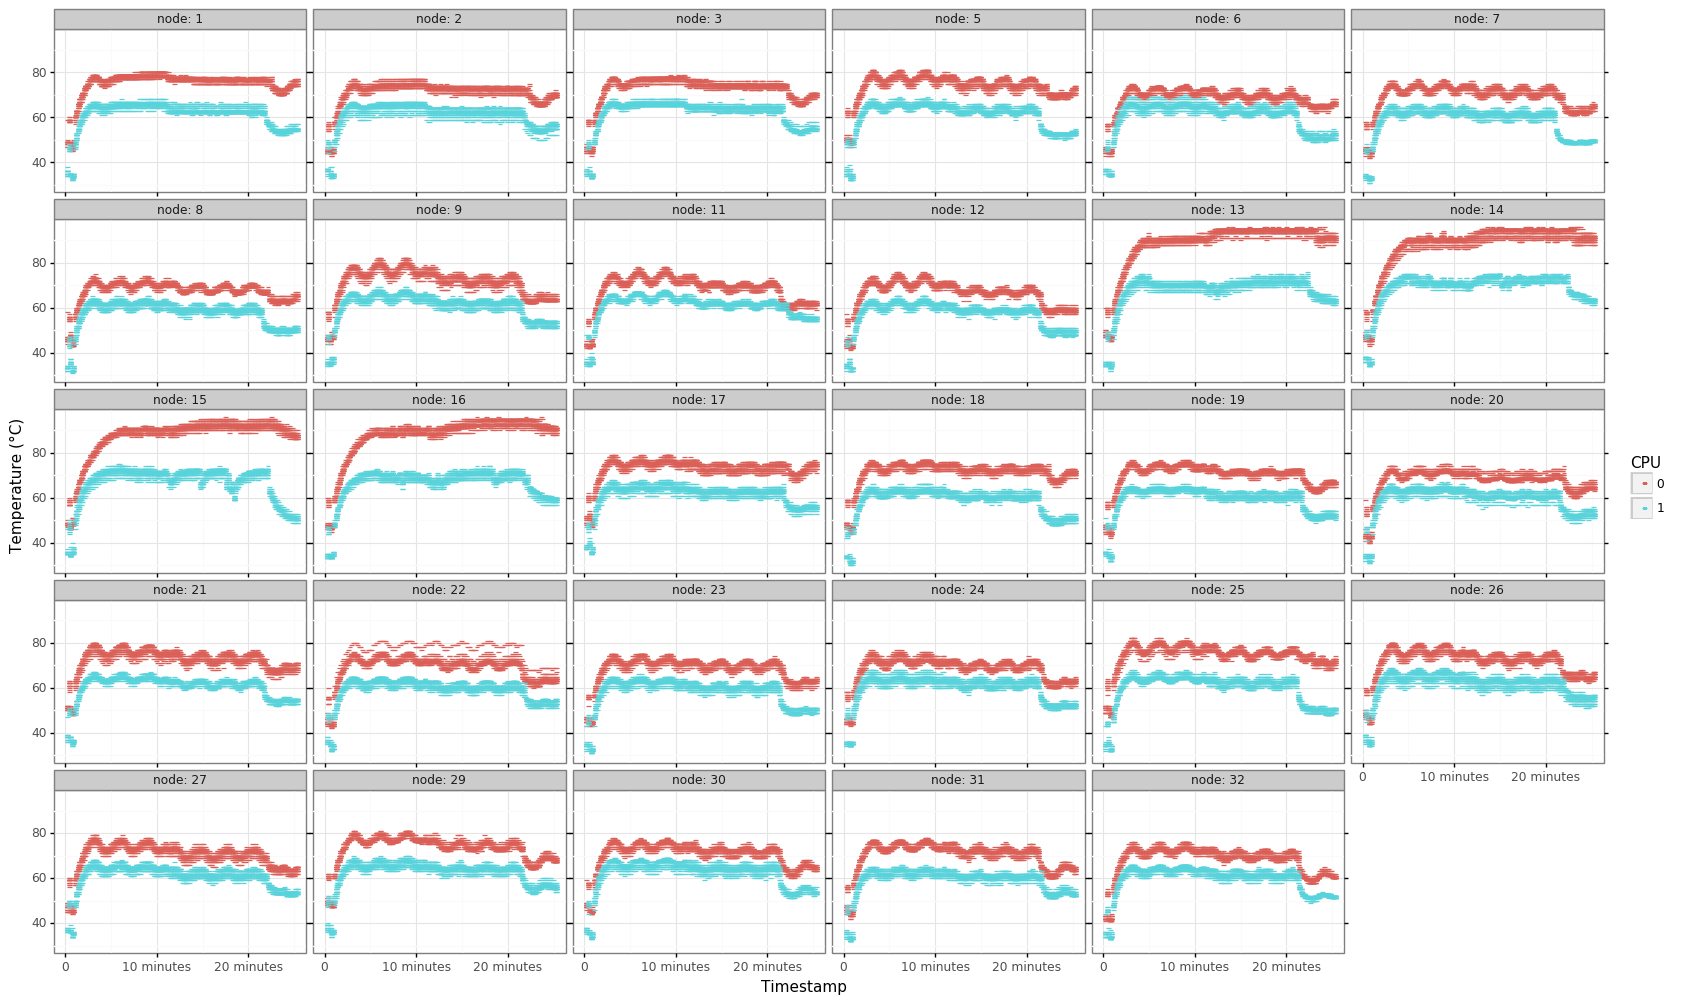

<ggplot: (-9223363277034419540)>

In [13]:
plot = ggplot(temperature, aes(x='start', y='temperature_core_', color='factor(cpu)')) + geom_point(shape=1)
plot = plot + facet_wrap('node', labeller='label_both') + theme_bw() + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='CPU')
plot

In [14]:
frequency = my_melt(monitoring, 'frequency_core_', ['hostname', 'start', 'node'])
frequency = frequency[frequency['group'] <= max(mapping.keys())]  # removing the cores with largest IDs (they are not real cores, just hyperthreads)
frequency['cpu'] = frequency.apply(lambda row: mapping[row.group], axis=1)
frequency['frequency_core_'] *= 1e-9
print(len(frequency))
frequency.head()

140128


,hostname,start,node,frequency_core_,group,cpu
0,dahu-1.grenoble.grid5000.fr,00:00:00,1,2.941717,0,0
1,dahu-1.grenoble.grid5000.fr,00:00:10.014307,1,2.775347,0,0
2,dahu-1.grenoble.grid5000.fr,00:00:20.036133,1,1.159716,0,0
3,dahu-1.grenoble.grid5000.fr,00:00:30.053611,1,1.024108,0,0
4,dahu-1.grenoble.grid5000.fr,00:00:40.092994,1,1.598199,0,0


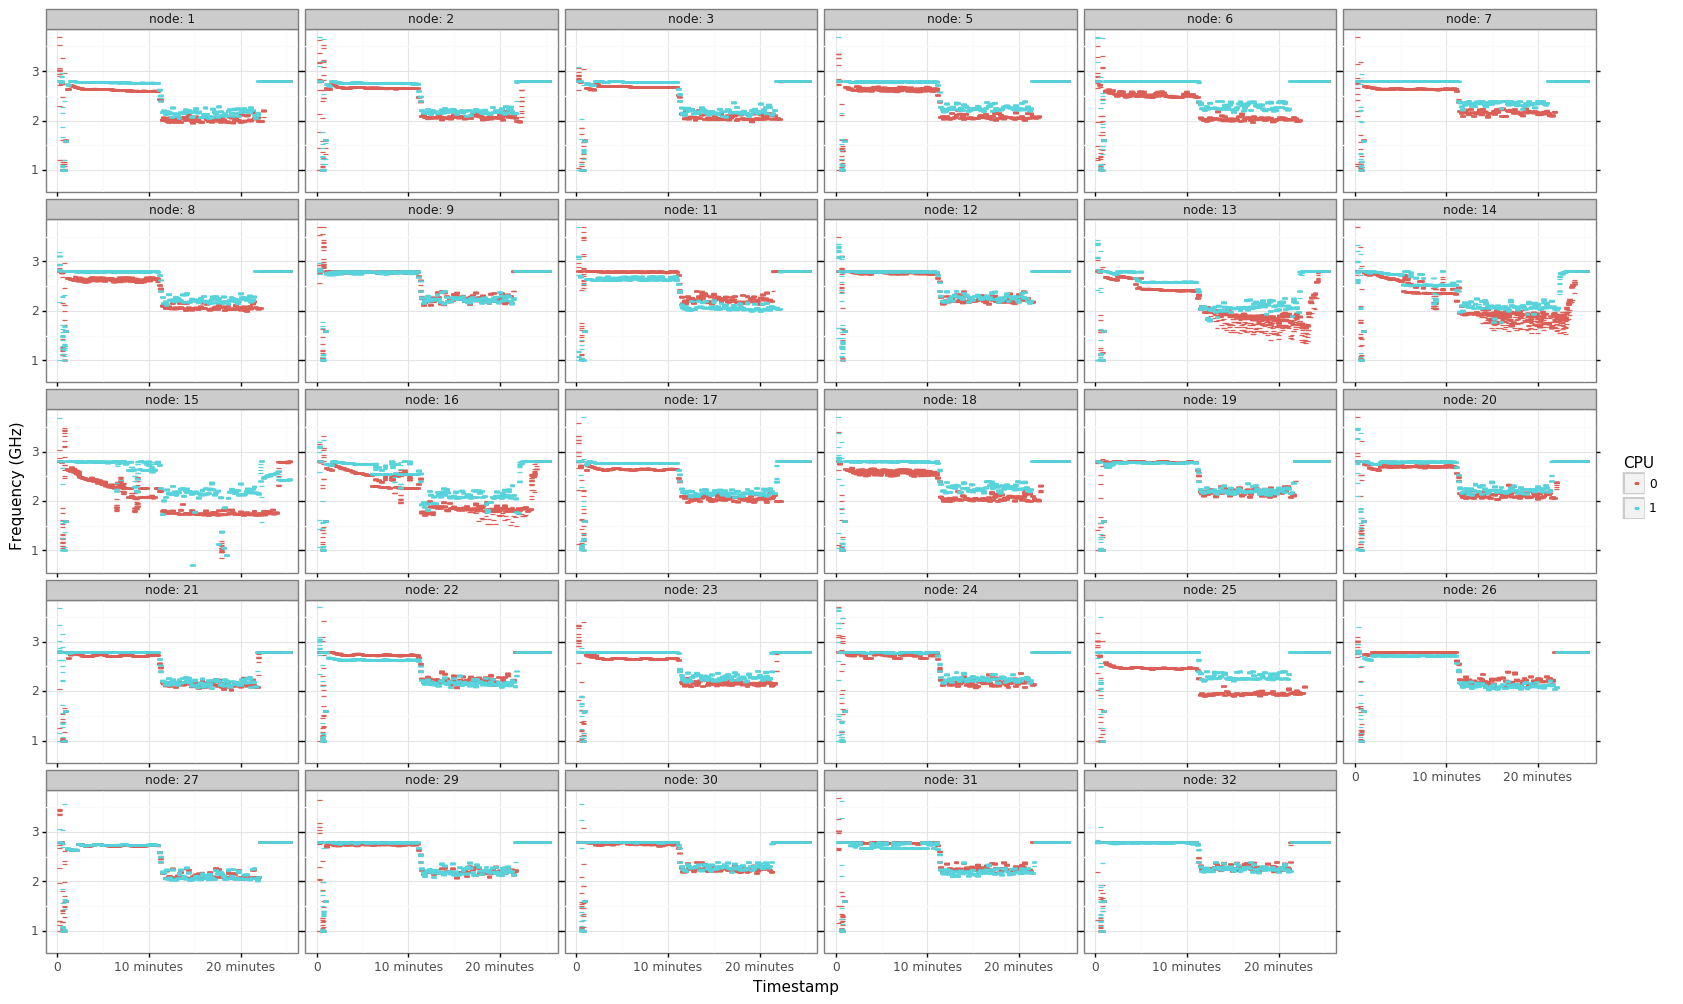

<ggplot: (8759800749404)>

In [15]:
plot = ggplot(frequency, aes(x='start', y='frequency_core_', color='factor(cpu)')) + geom_point(shape=1)
plot = plot + facet_wrap('node', labeller='label_both') + theme_bw() + xlab('Timestamp') + ylab('Frequency (GHz)') + labs(color='CPU')
plot

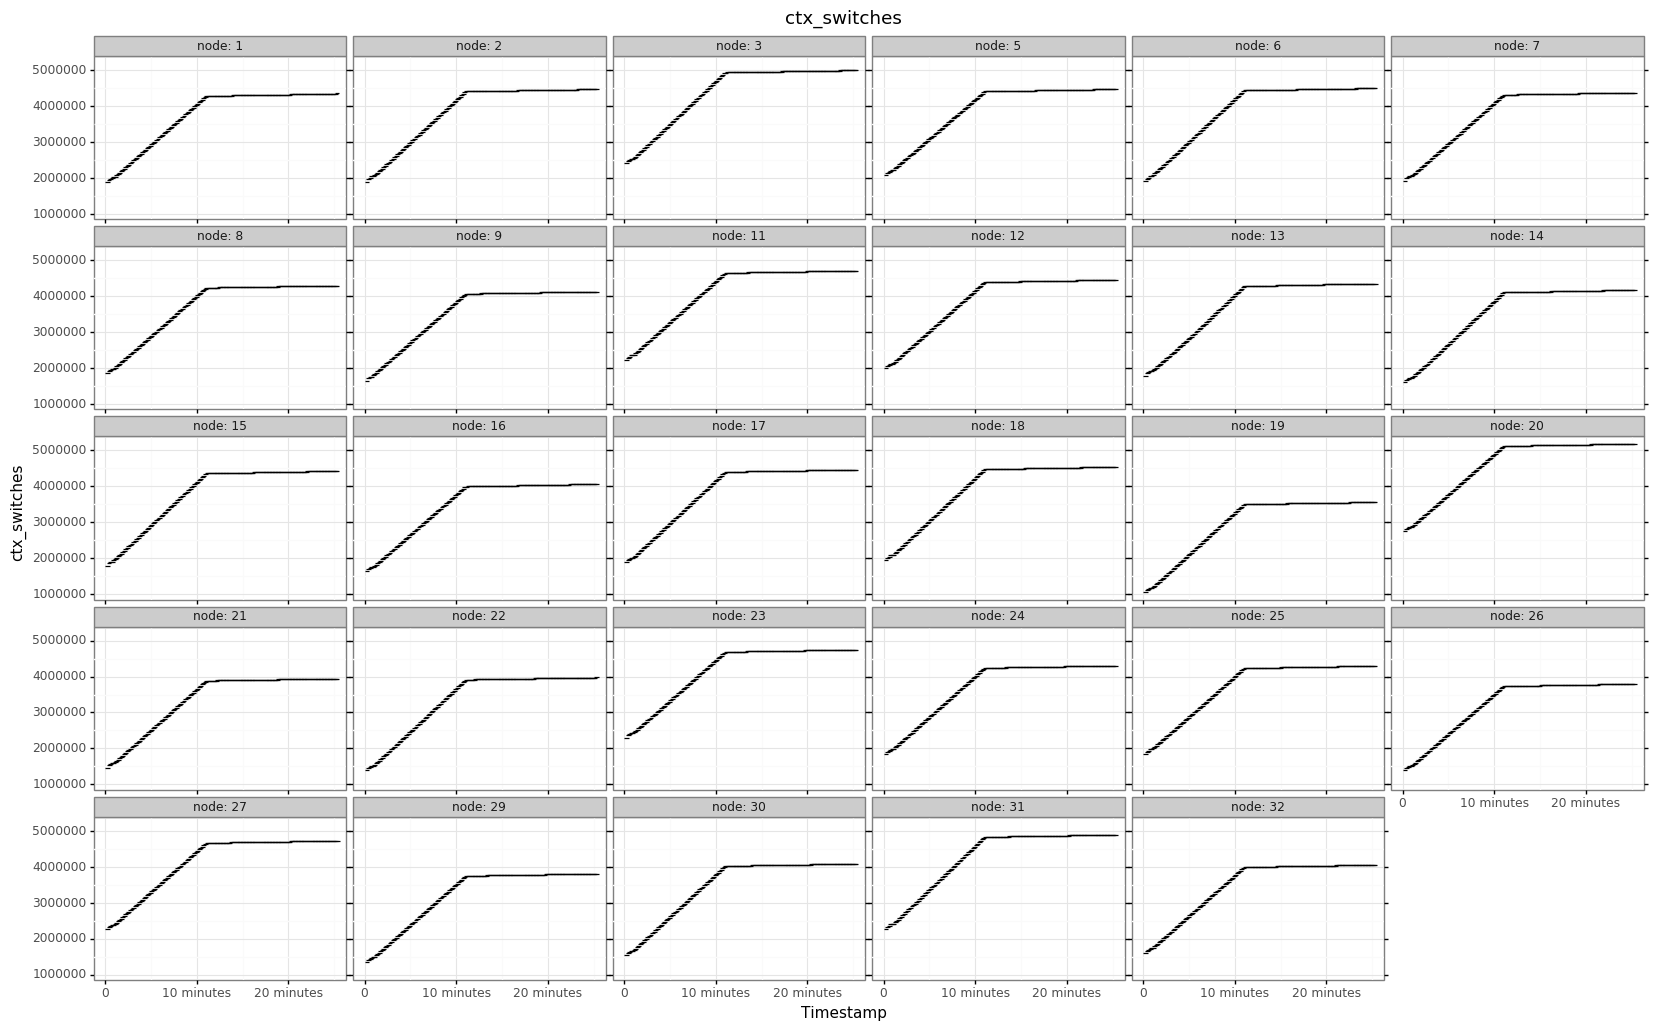

<ggplot: (-9223363277034225159)>


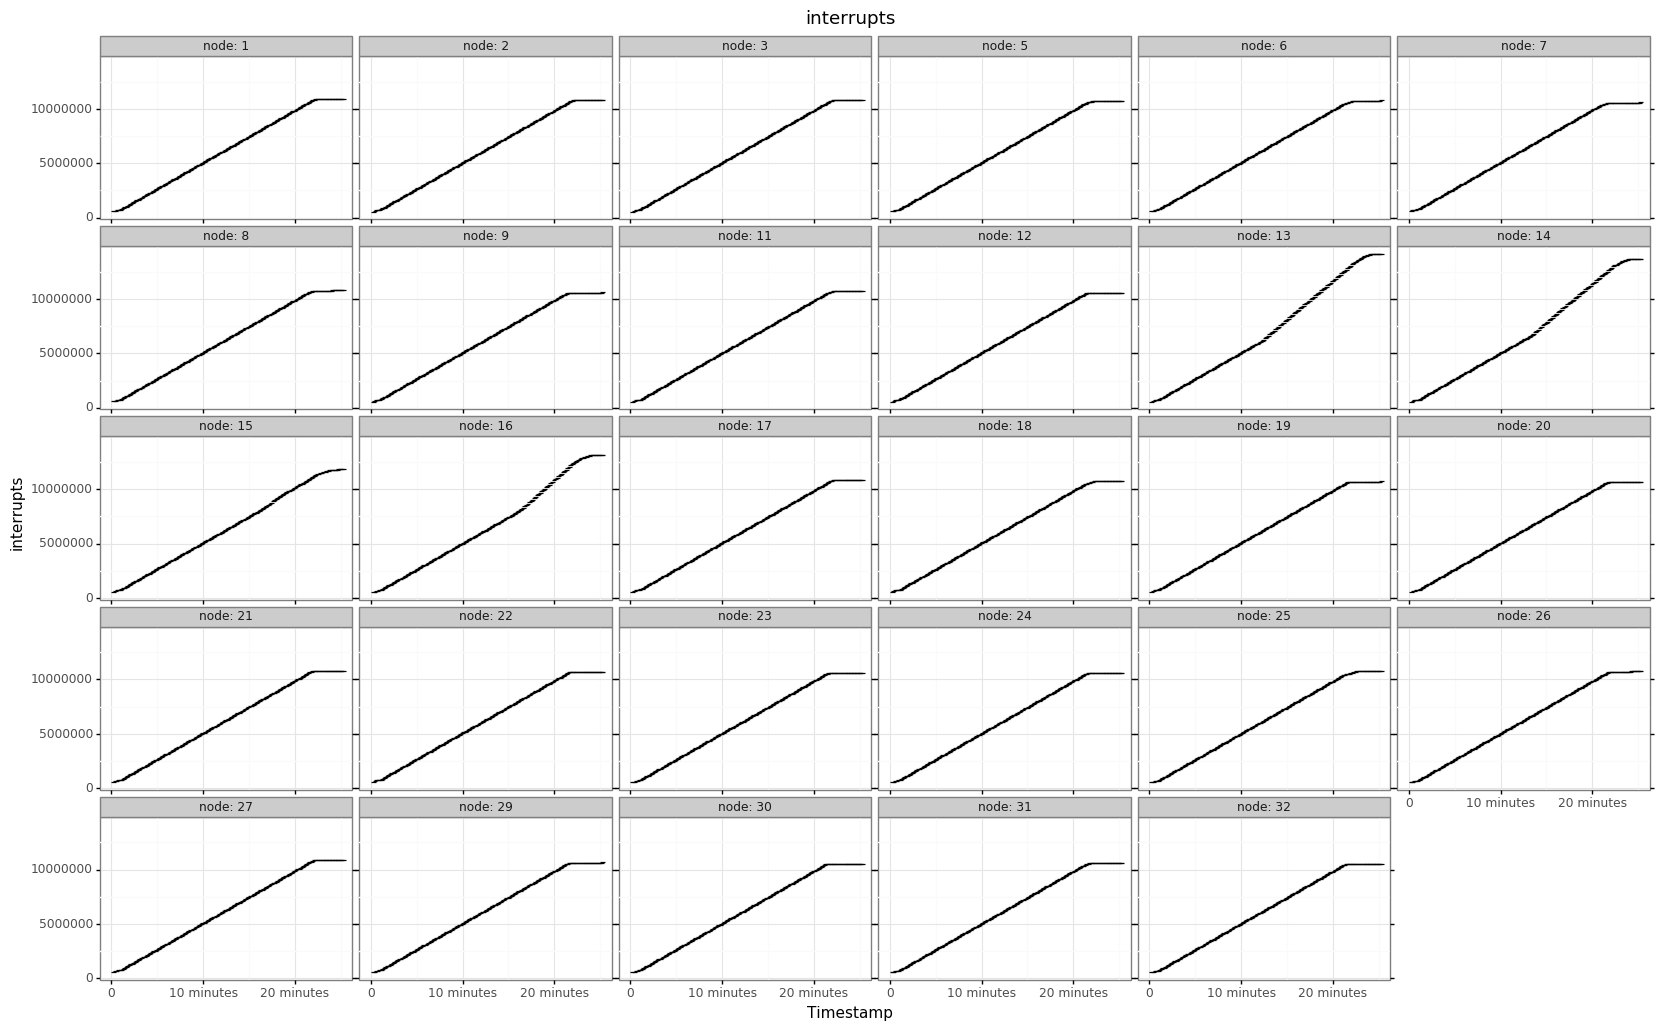

<ggplot: (8759803318641)>


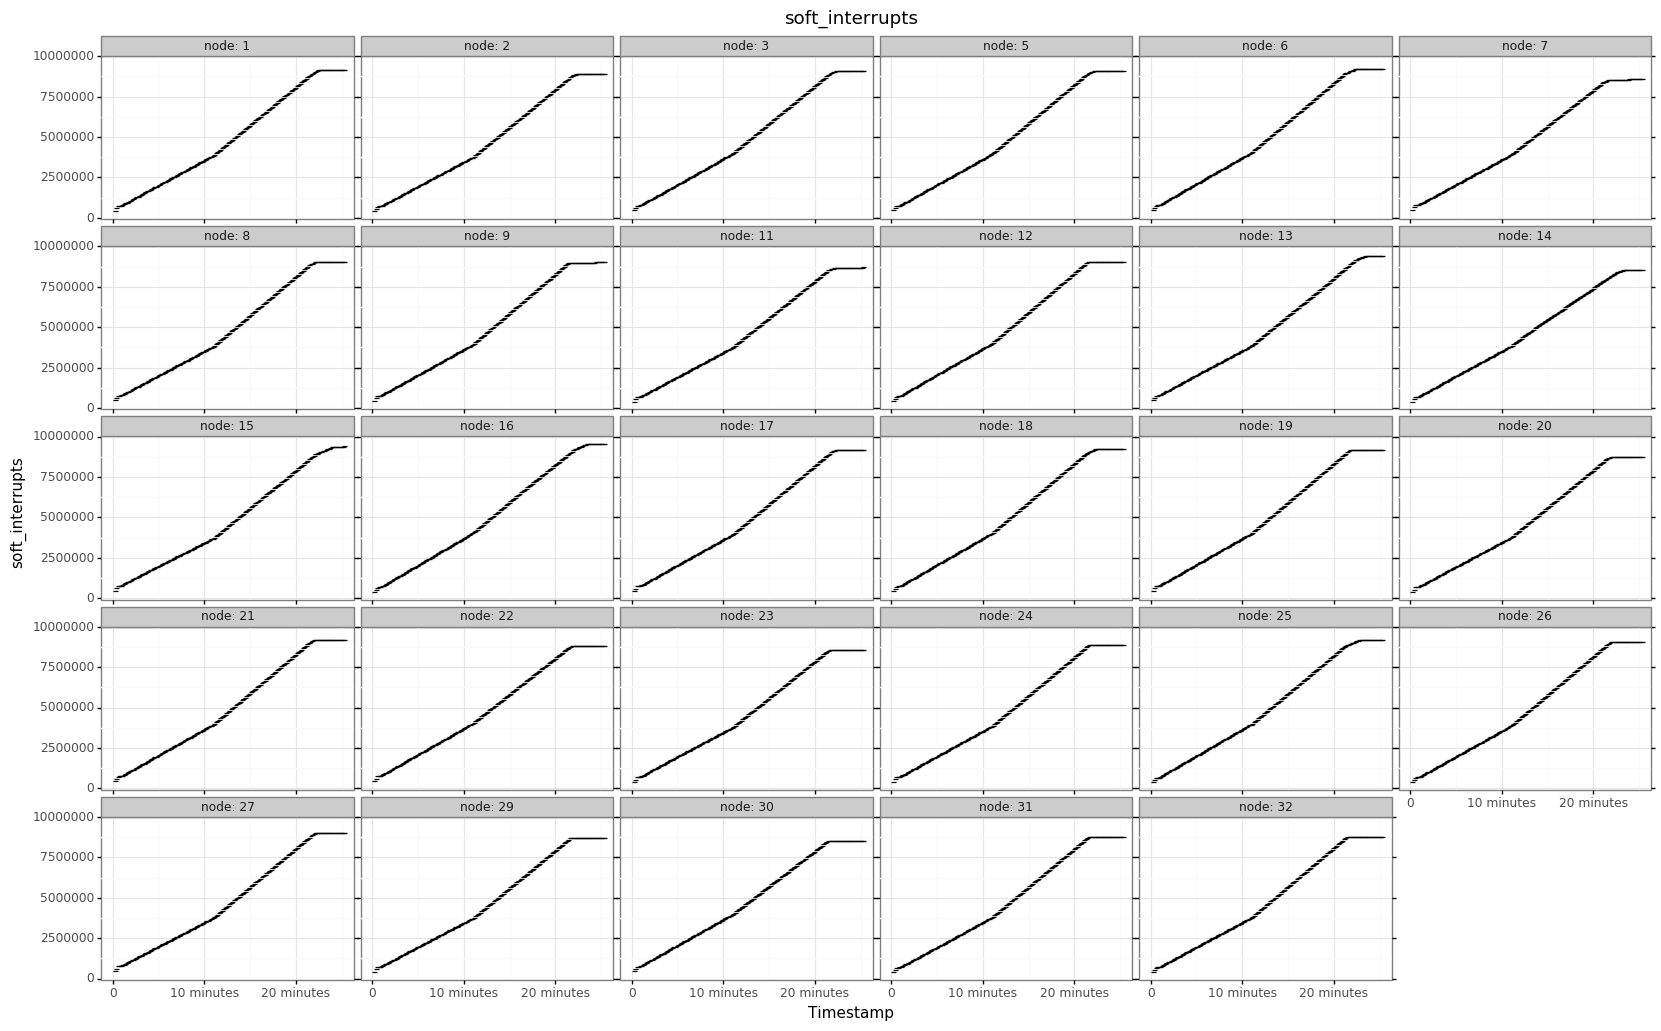

<ggplot: (-9223363277054521596)>


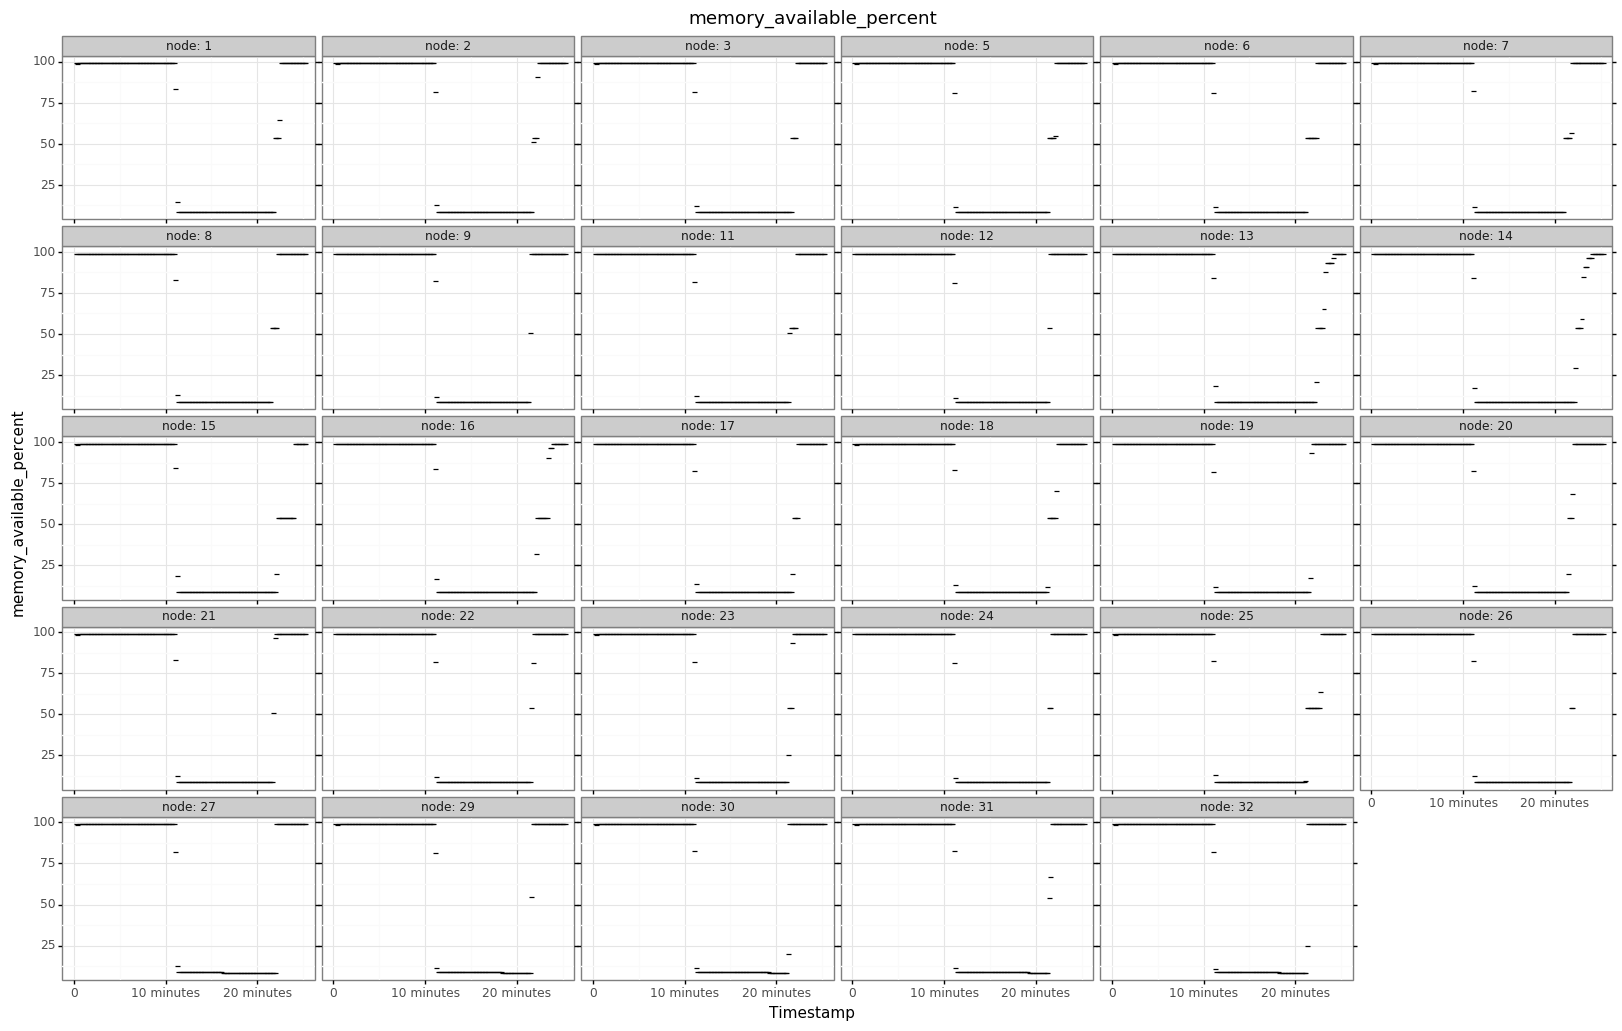

<ggplot: (8759811177855)>


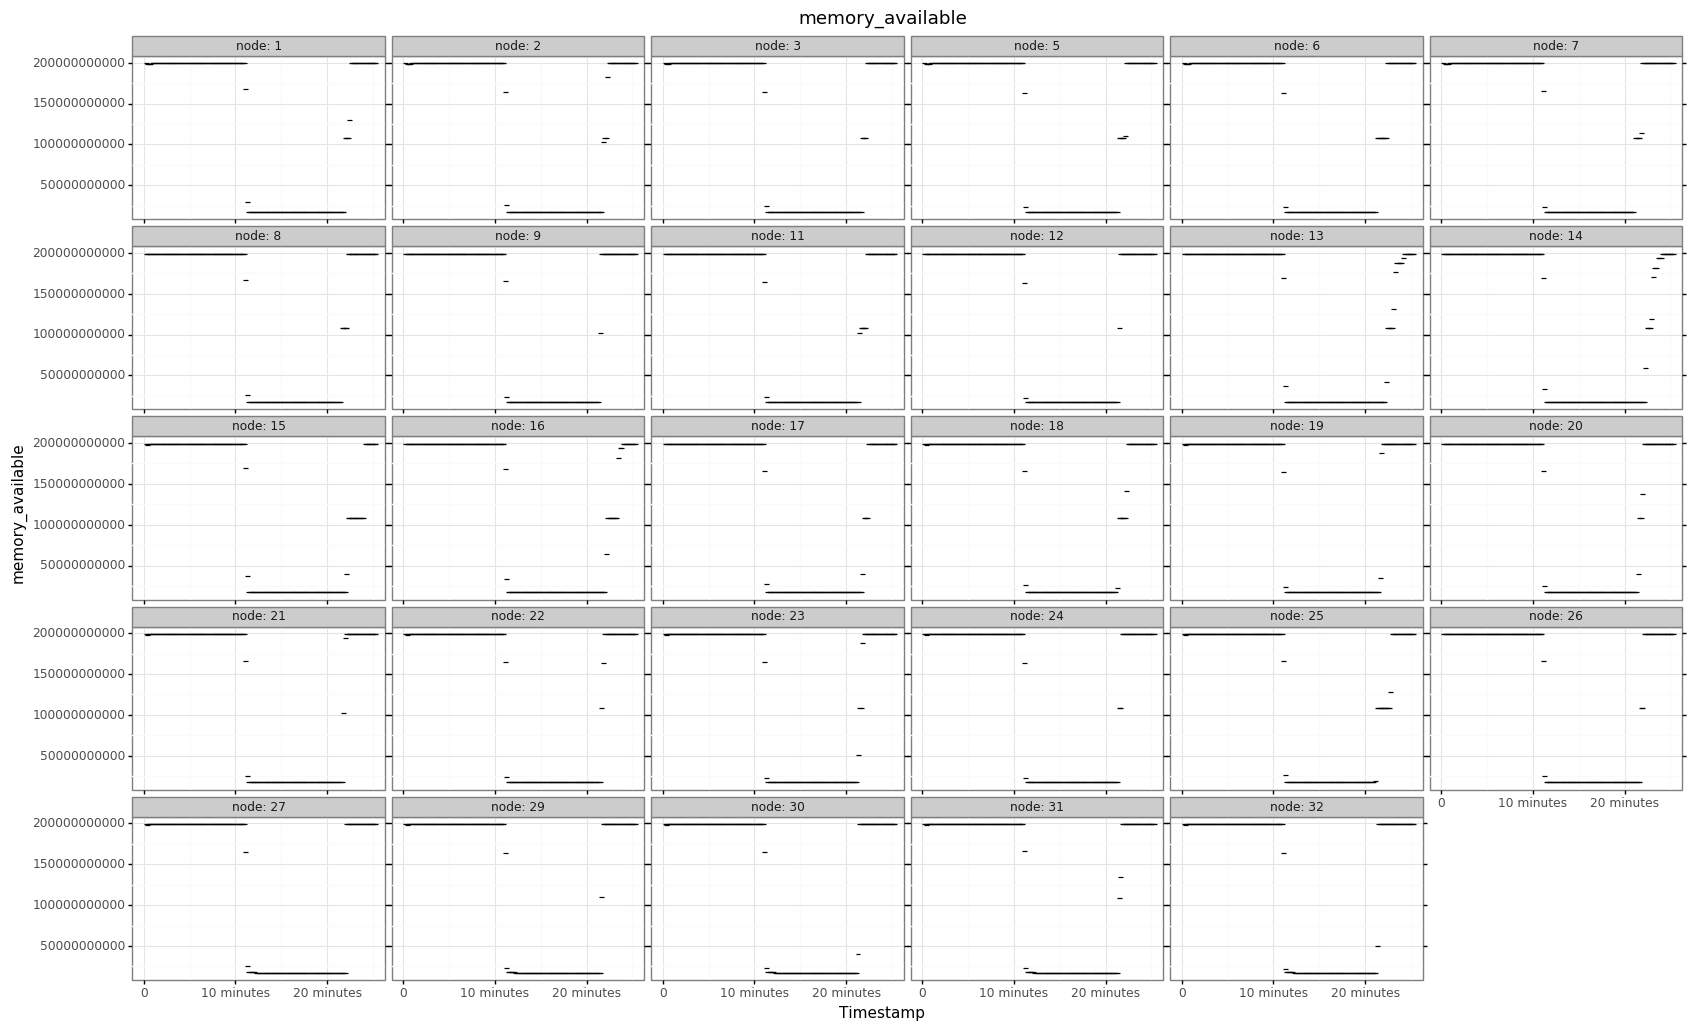

<ggplot: (-9223363277044730659)>


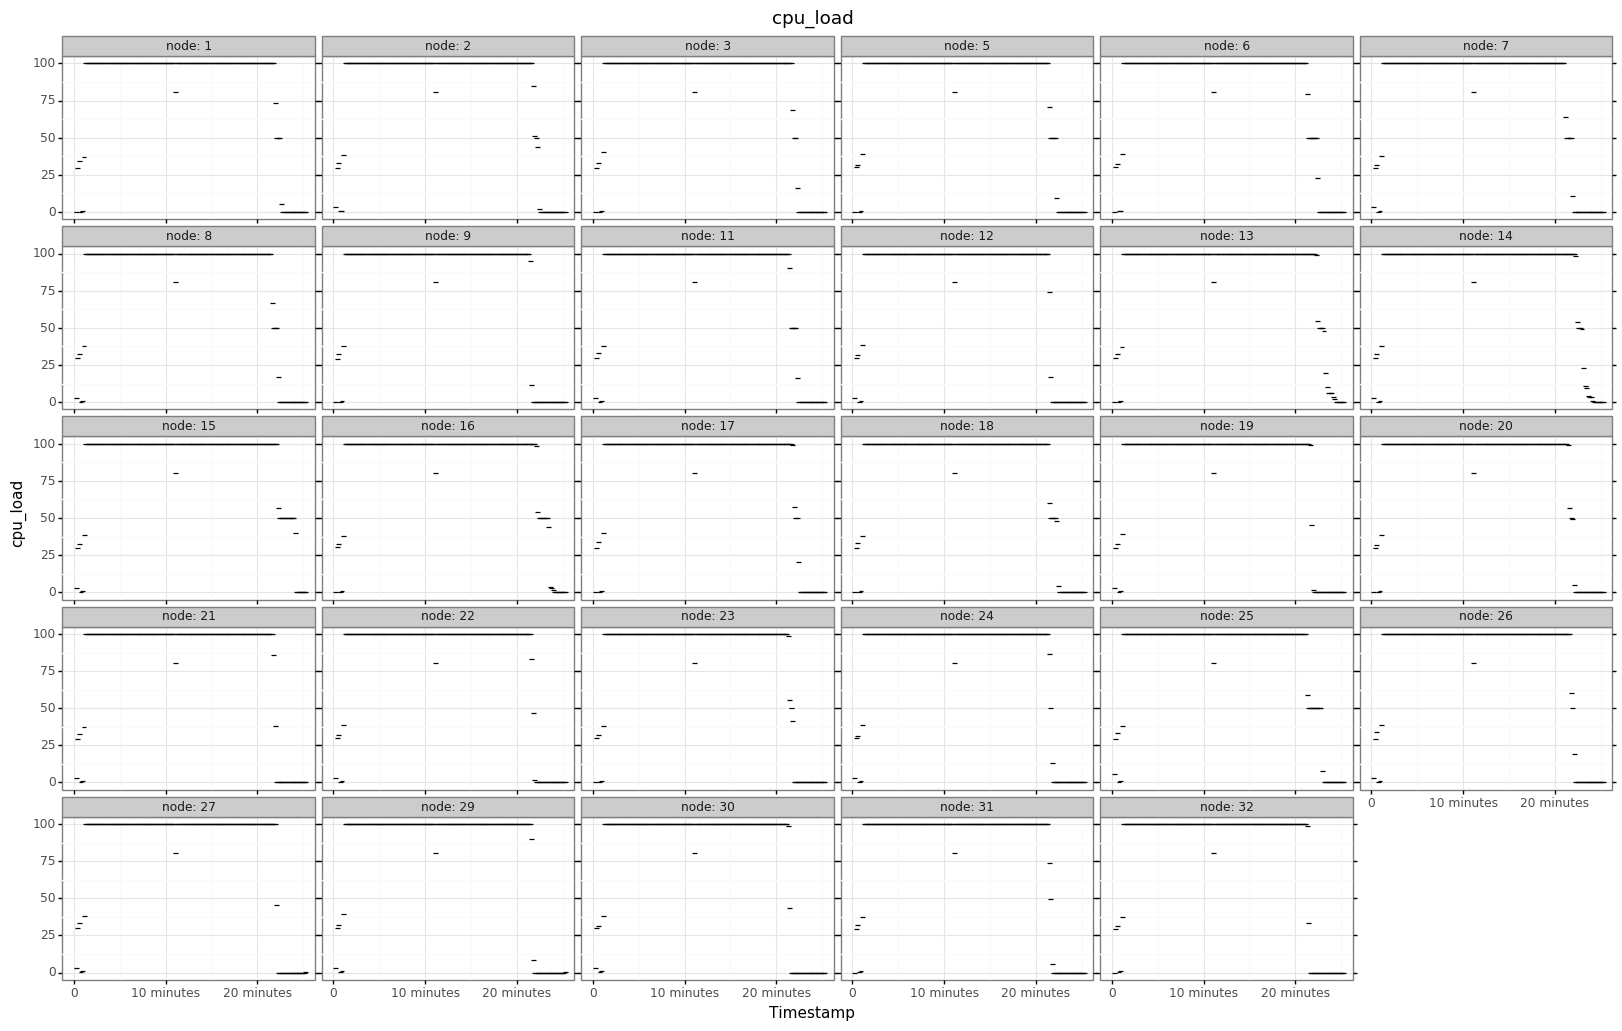

<ggplot: (8759811672226)>


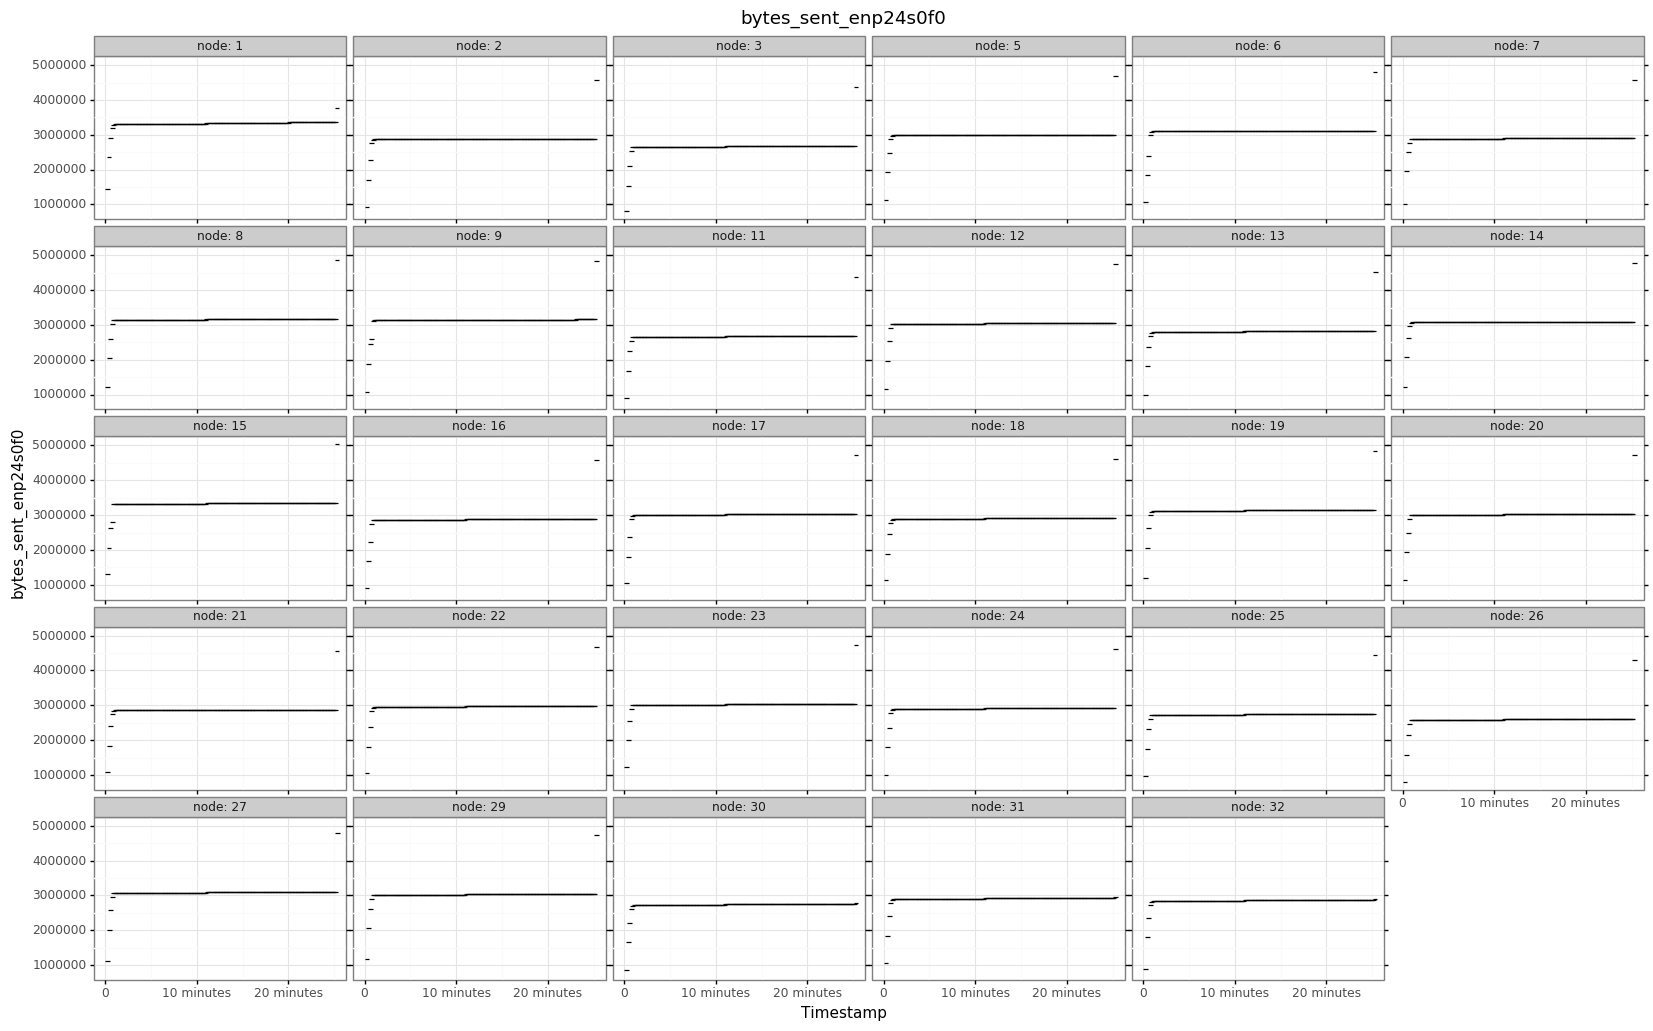

<ggplot: (-9223363277042554010)>


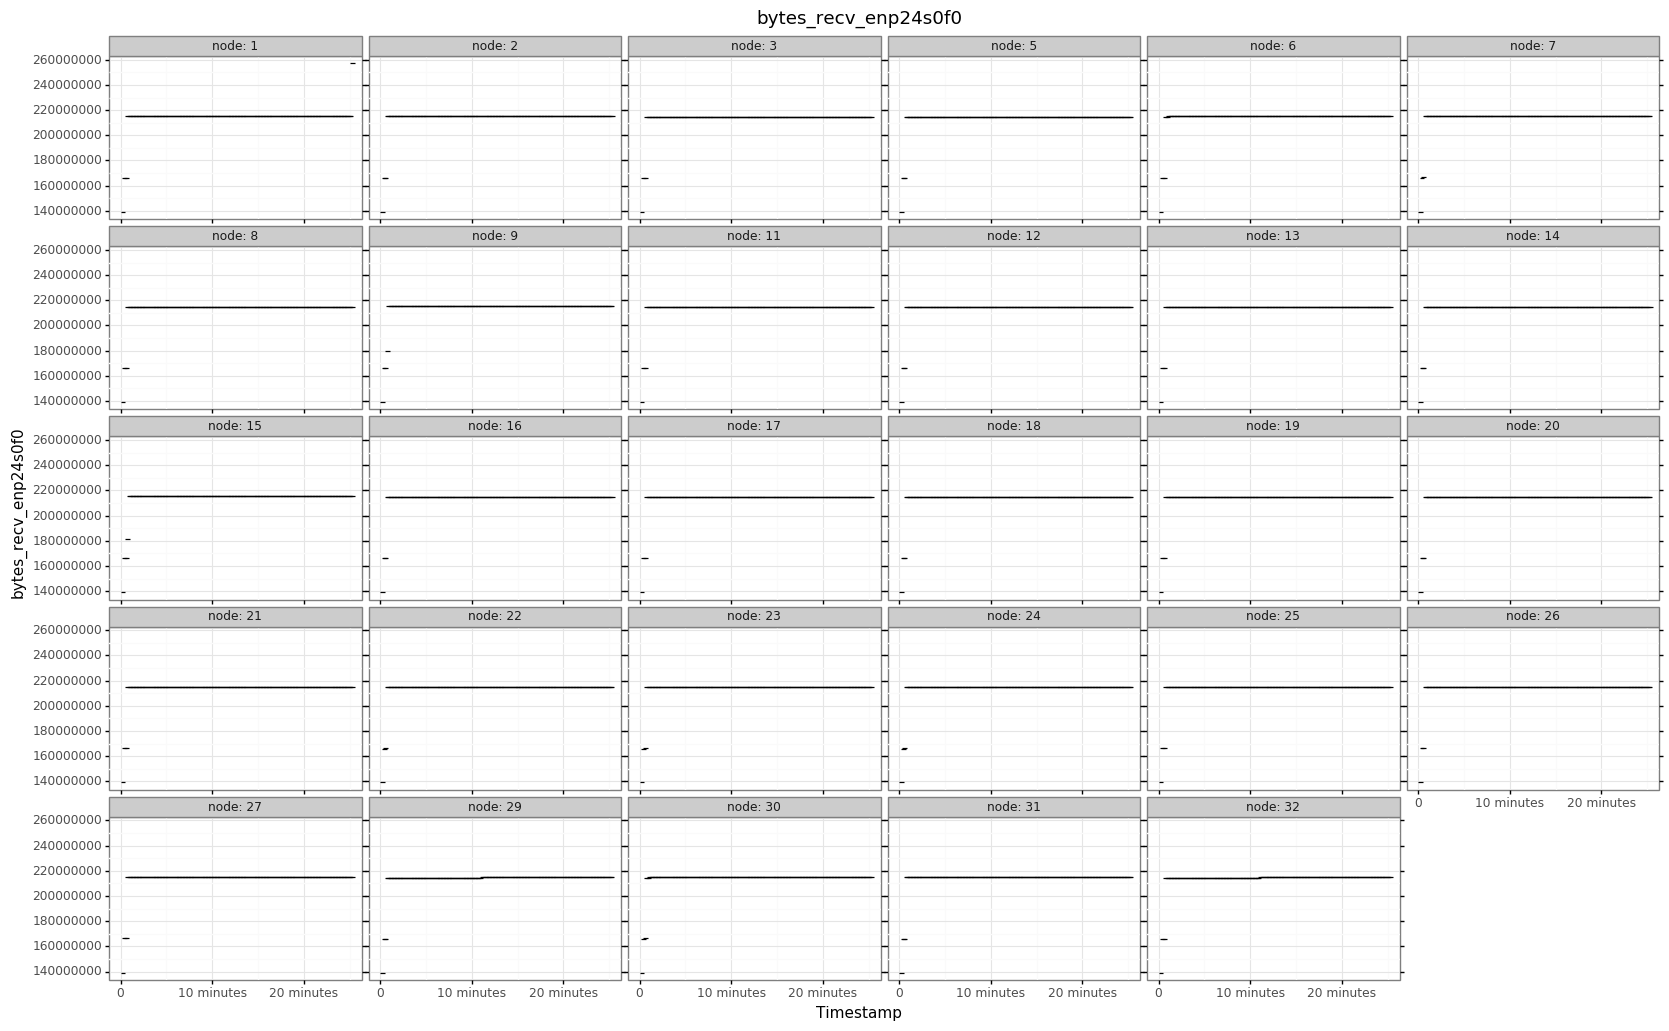

<ggplot: (8759811163112)>


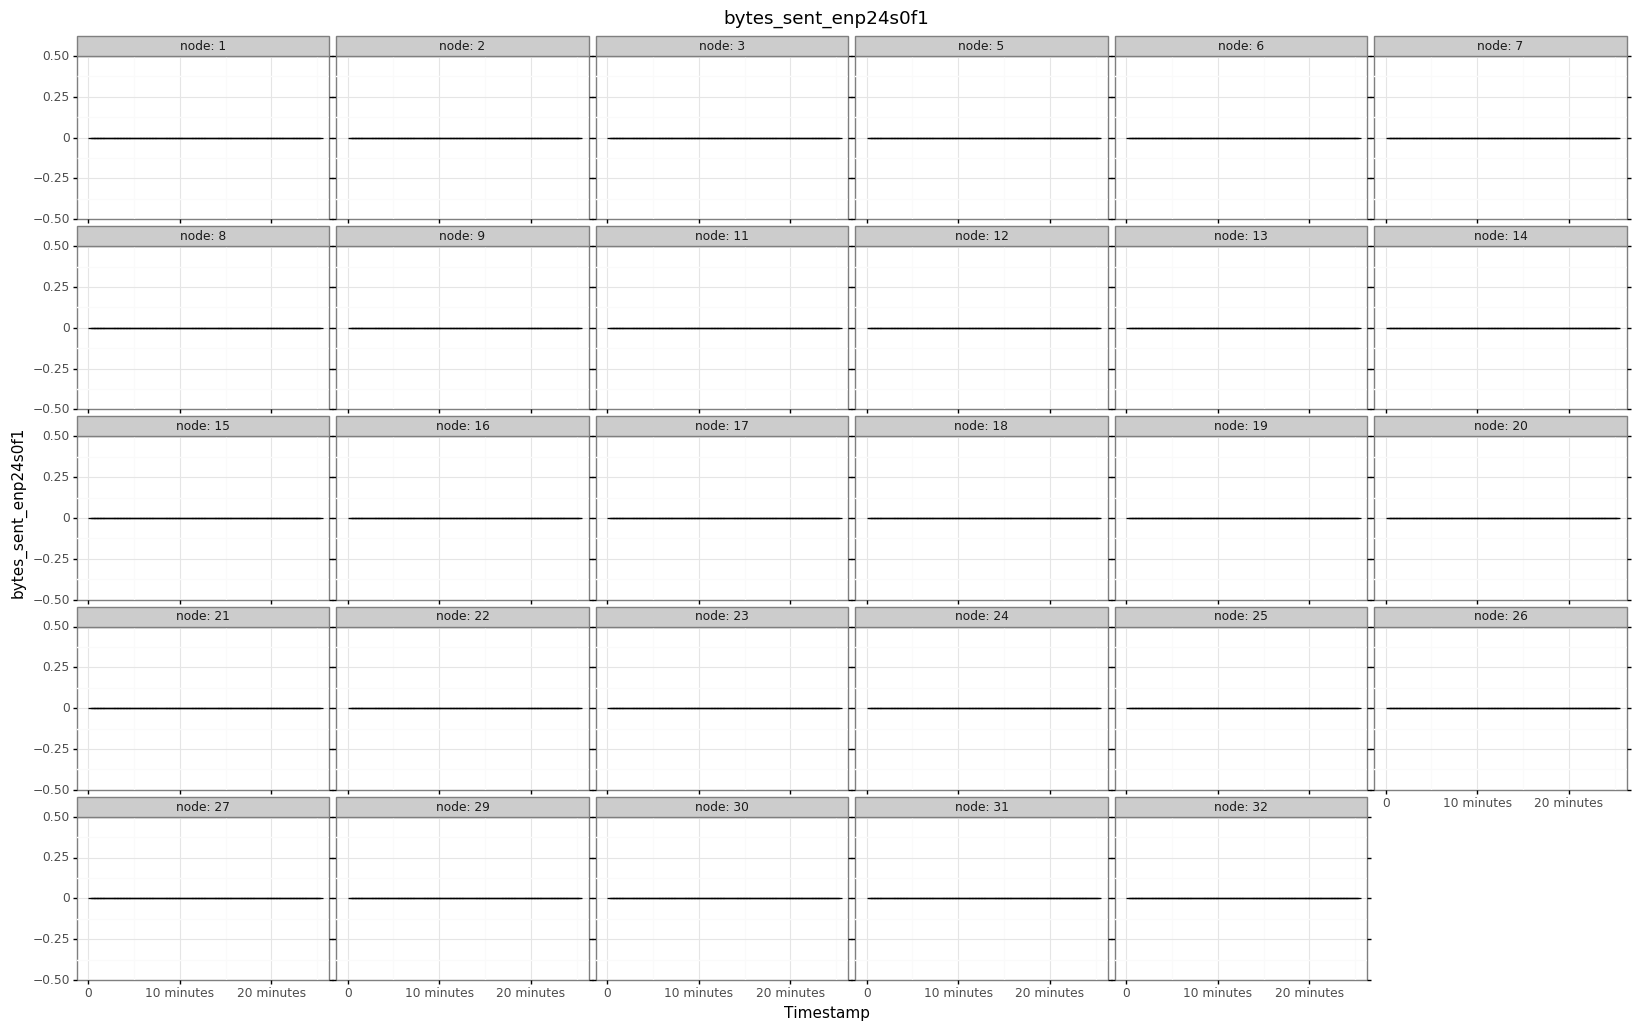

<ggplot: (-9223363277059425627)>


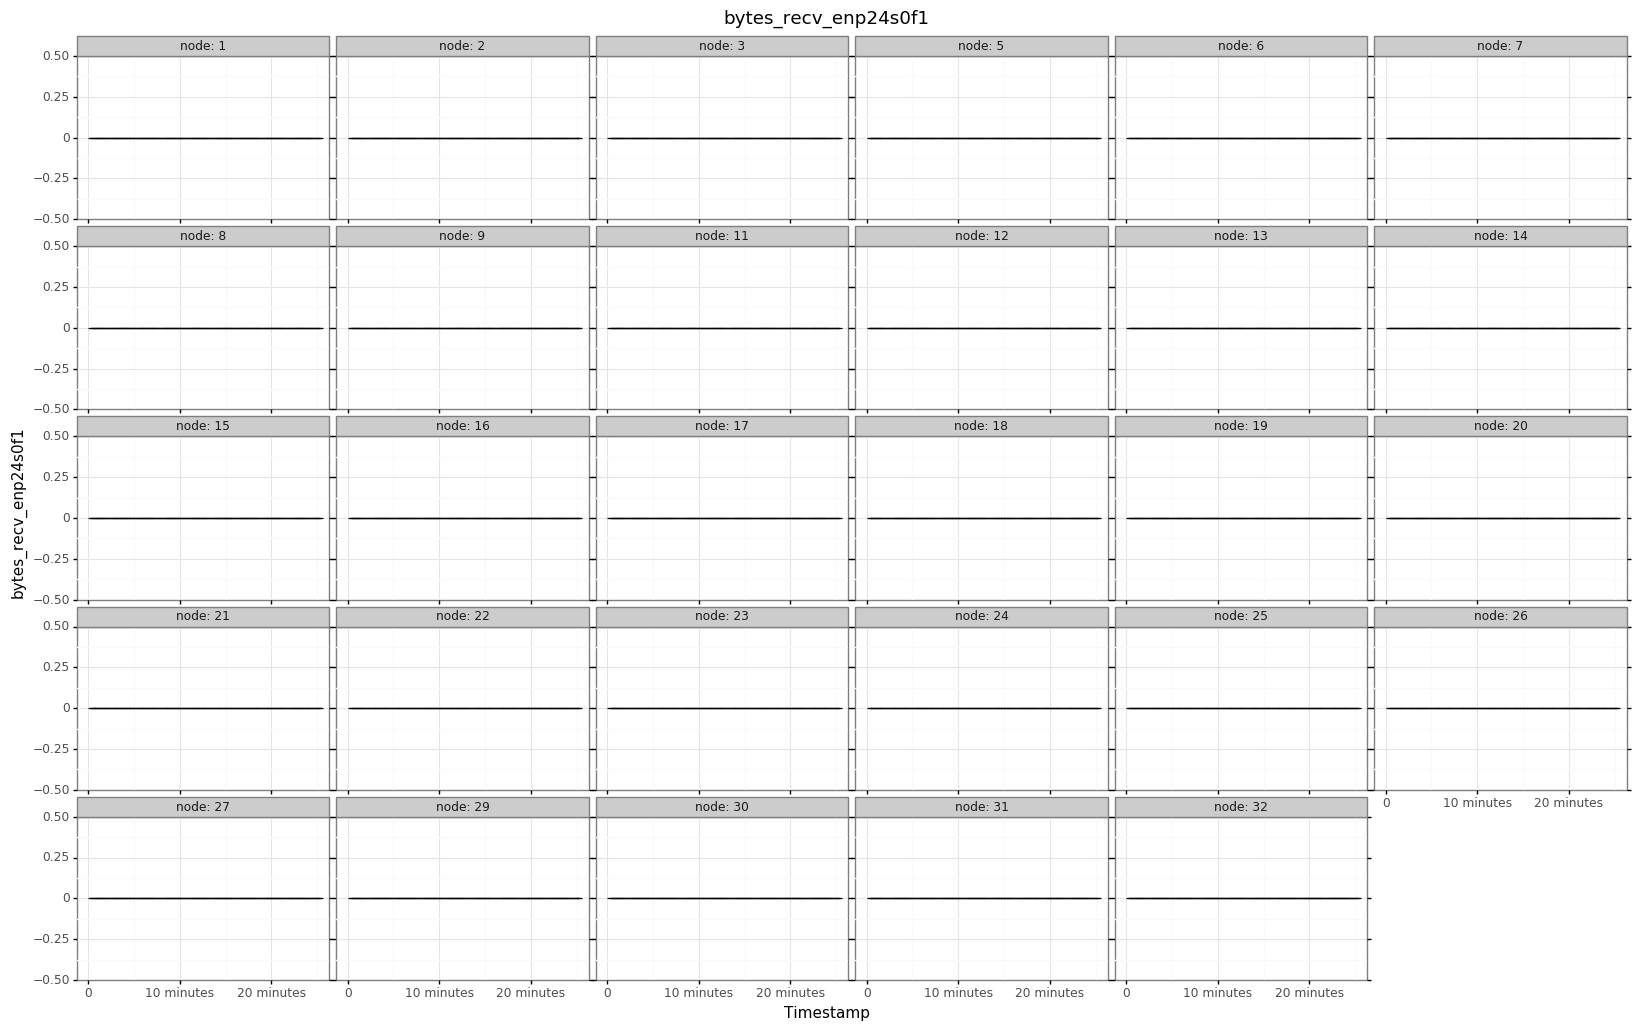

<ggplot: (8759811385278)>


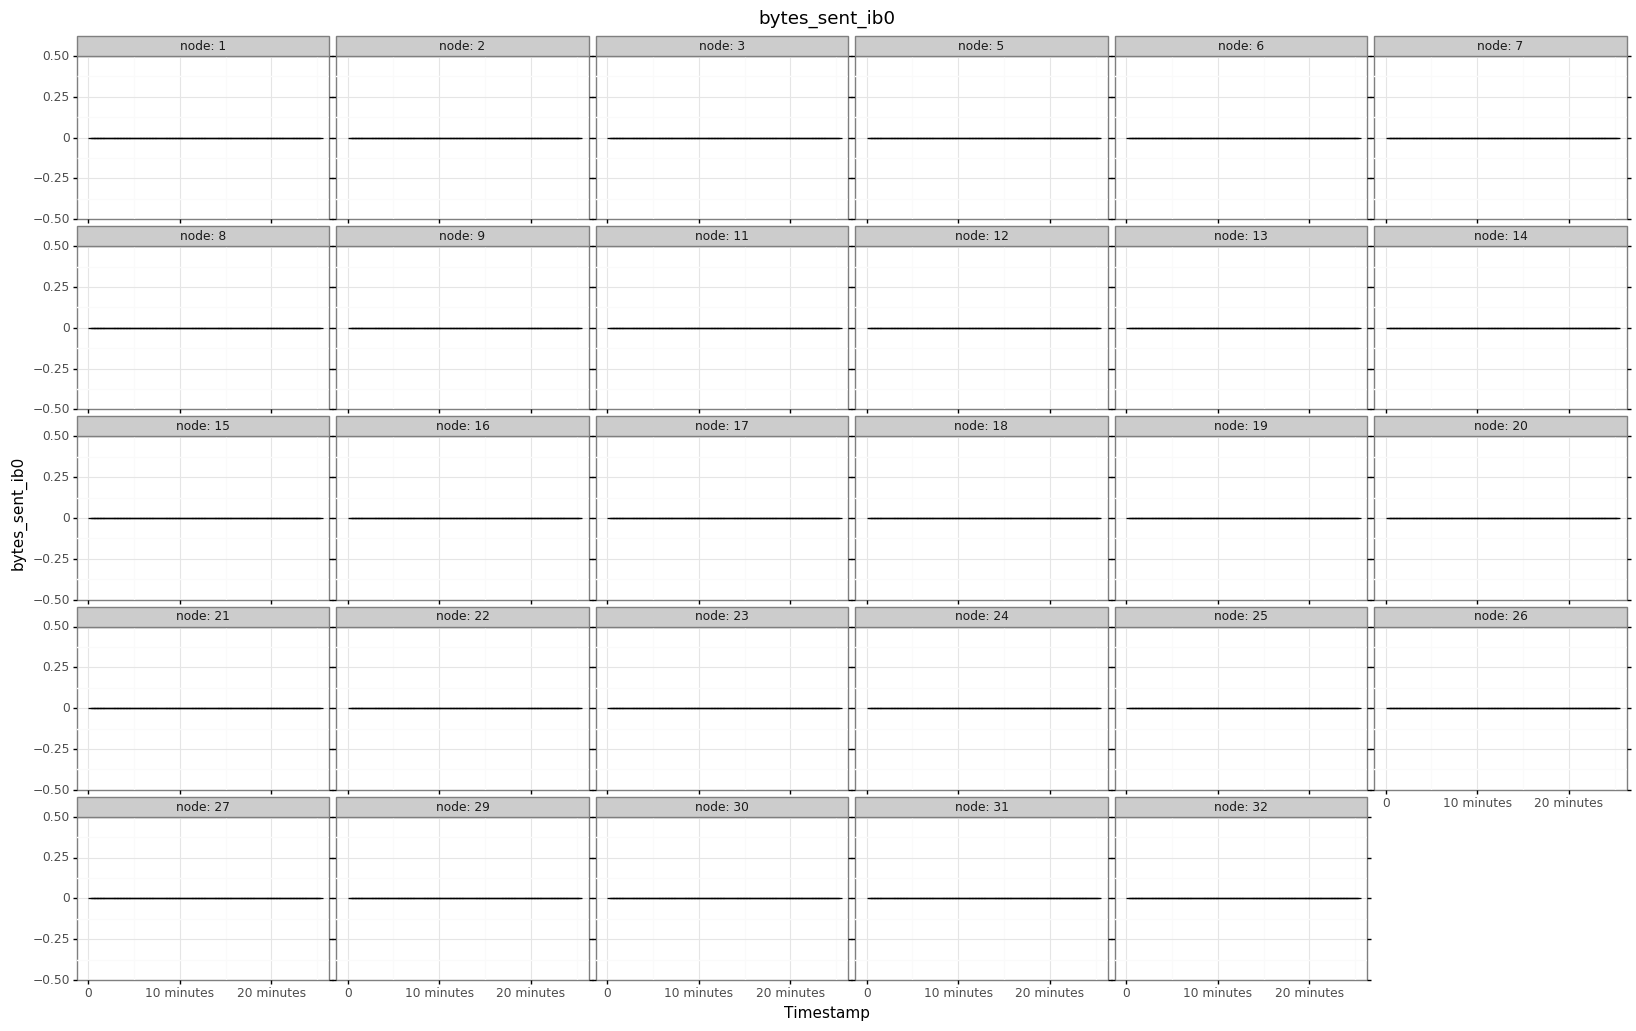

<ggplot: (8759811677248)>


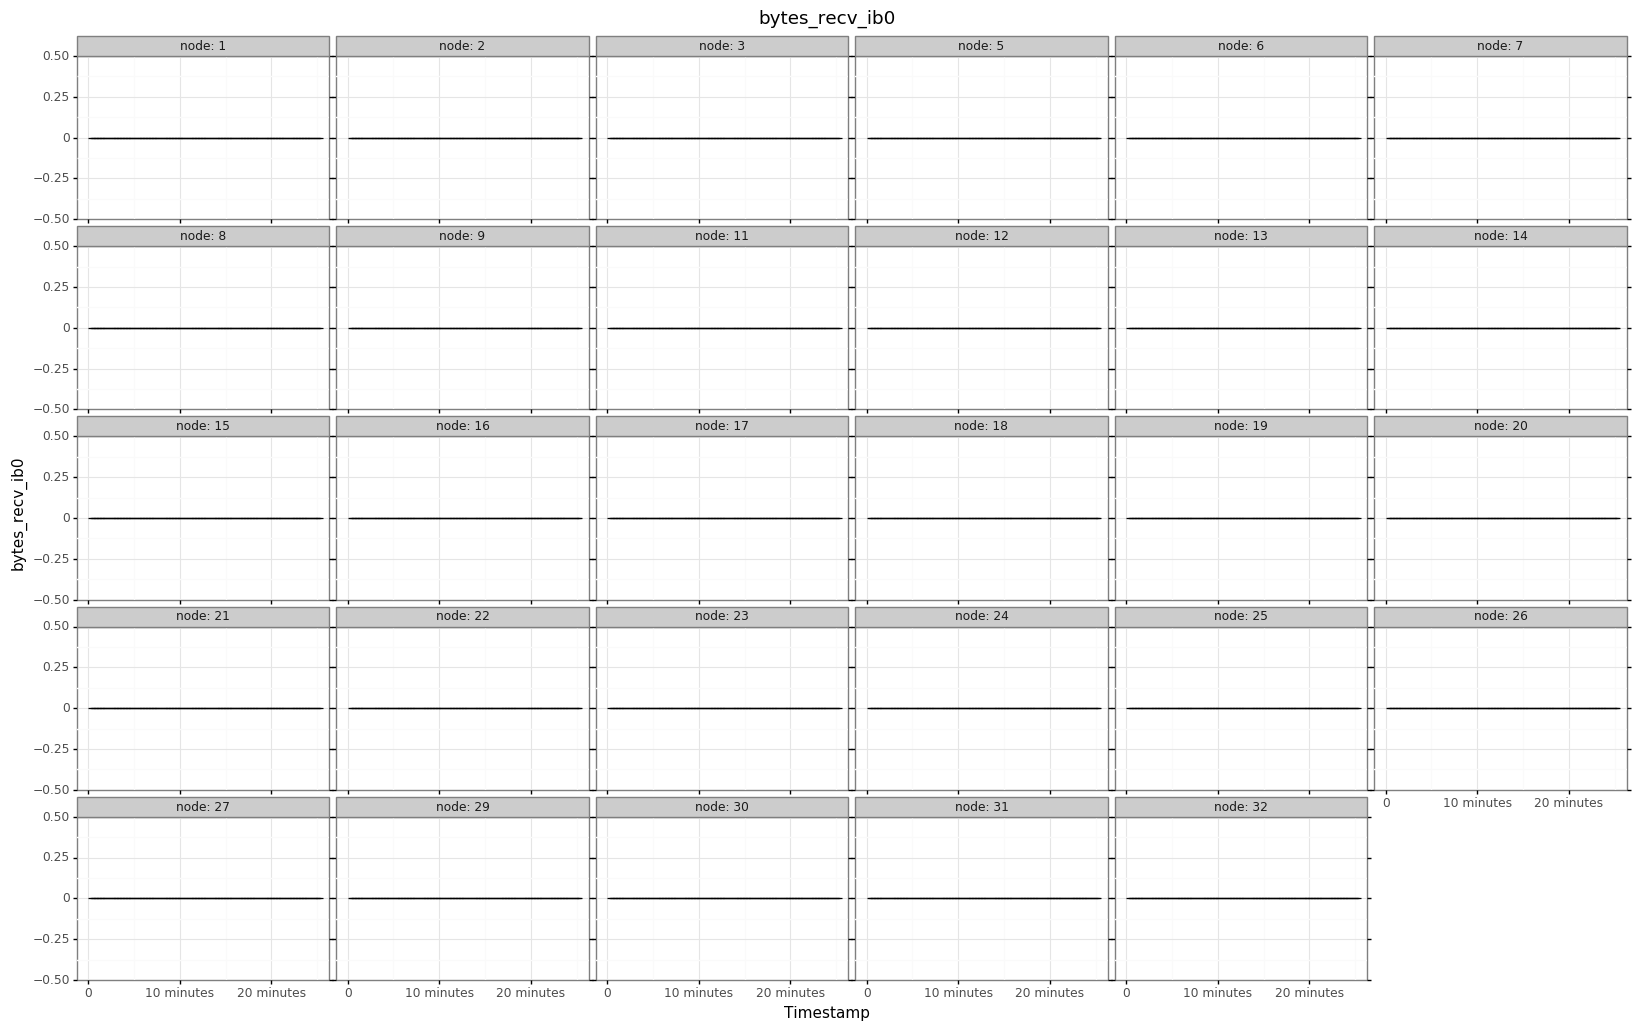

<ggplot: (8759834404051)>


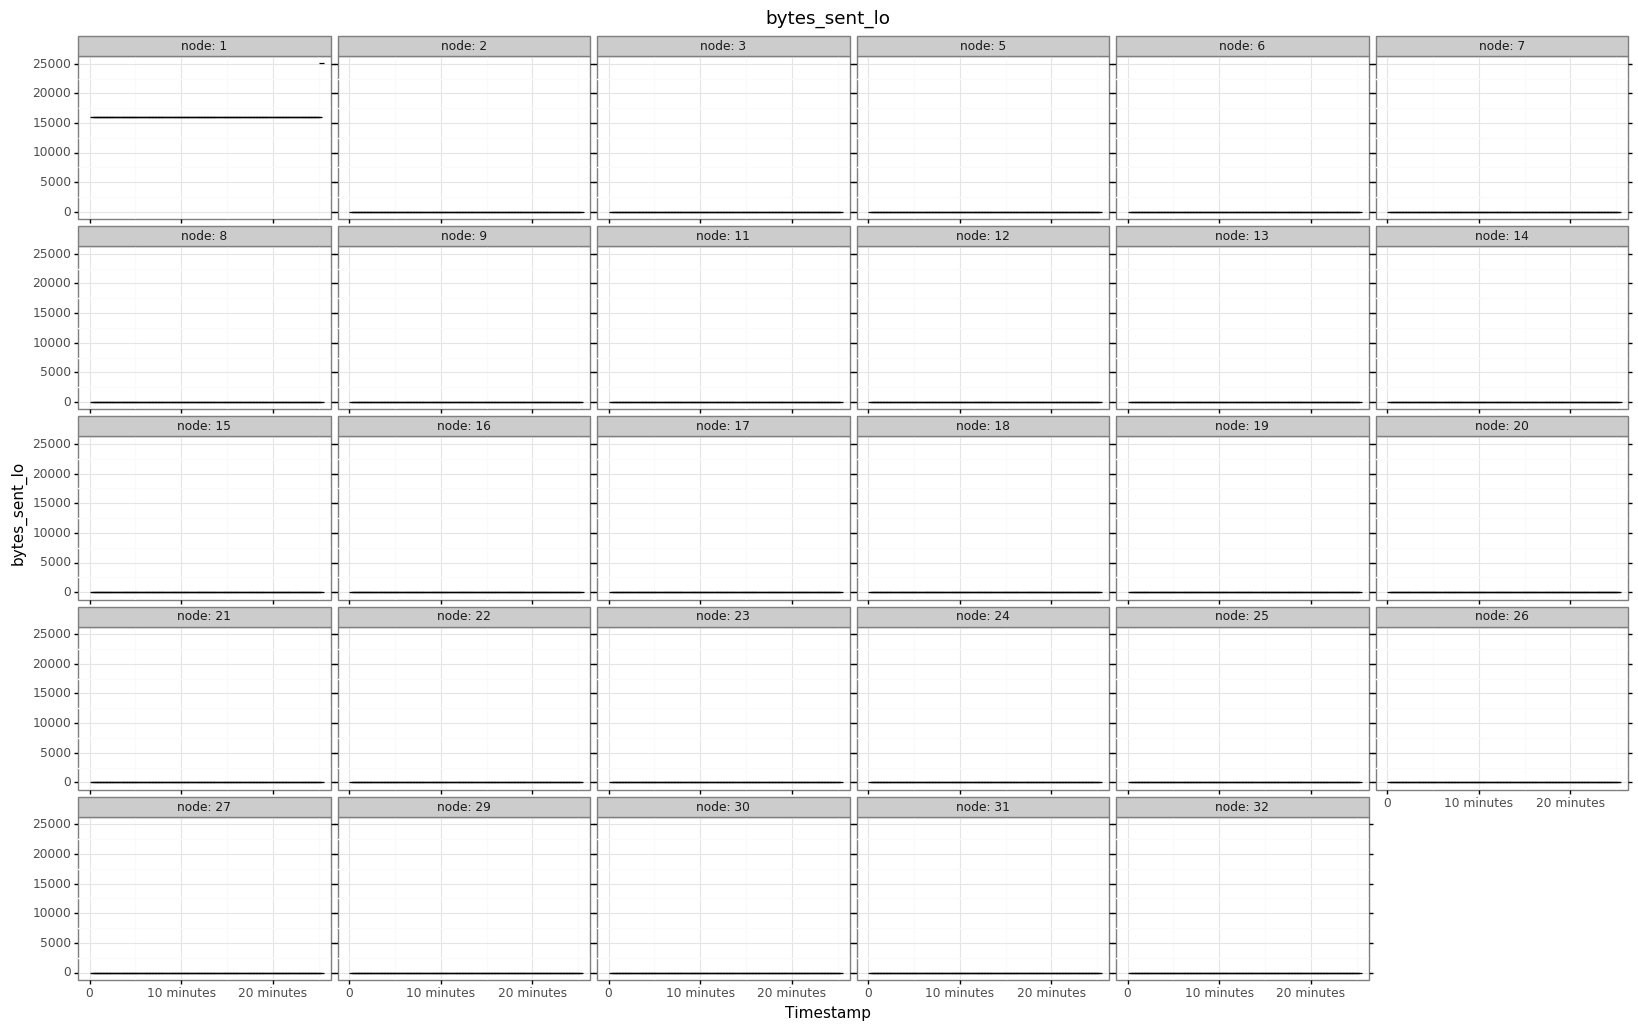

<ggplot: (-9223363277054420406)>


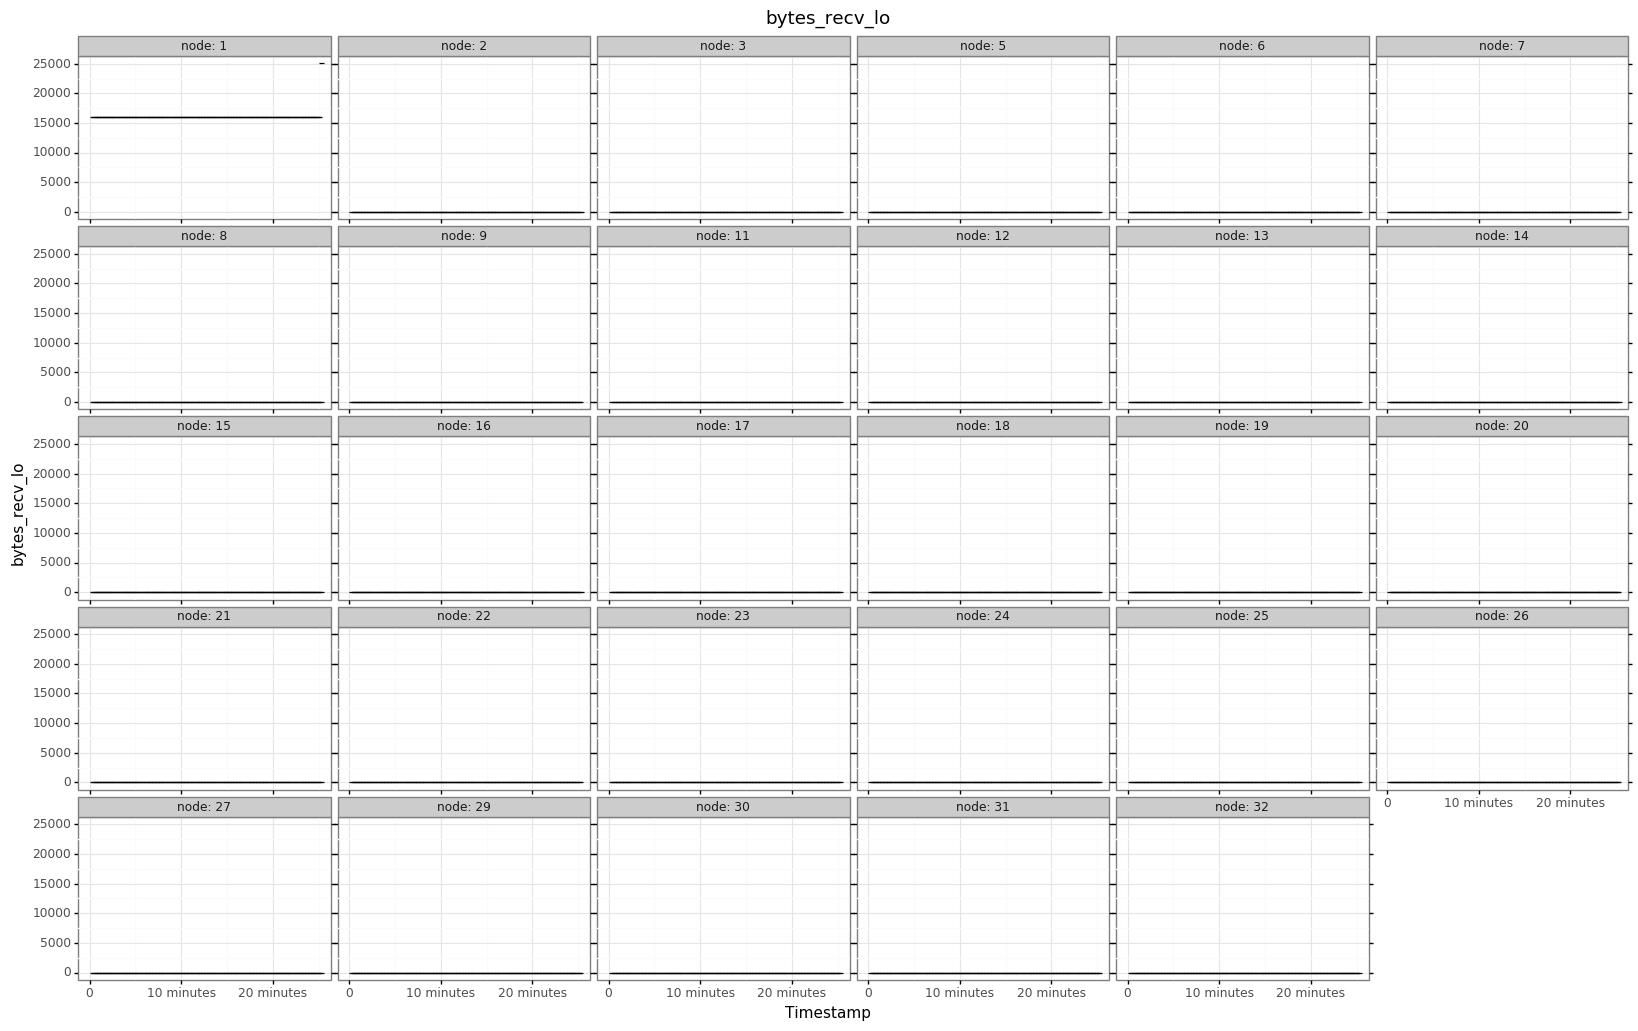

<ggplot: (8759802465726)>


In [16]:
columns = [col for col in monitoring.columns if '_core_' not in col and col not in ('hostname', 'node', 'timestamp', 'start')]
for col in columns:
    plot = ggplot(monitoring, aes(x='start', y=col)) + geom_point(shape=1)
    plot = plot + facet_wrap('node', labeller='label_both') + theme_bw() + xlab('Timestamp') + ggtitle(col)
    print(plot)